In [125]:
%run data_loader.py

Data loaded


## Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [170]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sn
import matplotlib.pyplot as plt
import itertools
import math

In [127]:
file_base_name = "data/BBC News {}.csv"
test_data = pd.read_csv(file_base_name.format("Test"))
train_data = pd.read_csv(file_base_name.format("Train"))

In [128]:
print(train_data.info())
print(train_data.describe())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [129]:
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [130]:
# Extracting labels
labels = train_data["Category"].unique().tolist()
labels

['business', 'tech', 'politics', 'sport', 'entertainment']

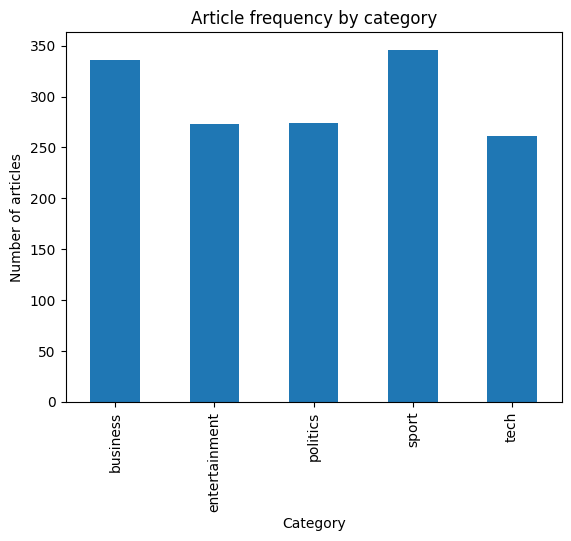

--Before filtering--
Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: ArticleId, dtype: int64
Mean:  298.0
--After filtering--


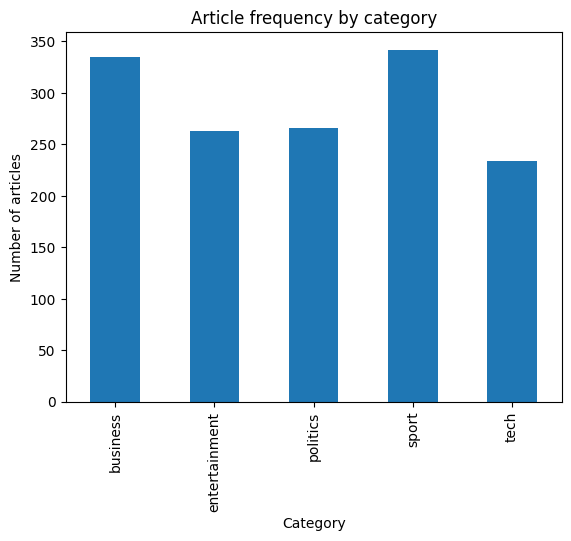

Category
business         335
entertainment    263
politics         266
sport            342
tech             234
Name: ArticleId, dtype: int64
Mean:  288.0


In [155]:
count_by_labels = train_data.groupby("Category").count().iloc[:,0]
count_by_labels.plot.bar(title="Article frequency by category", ylabel="Number of articles")
plt.show()
train_data.drop_duplicates(subset="Text",keep="first", inplace=True)
print("--Before filtering--")
print(count_by_labels)
print("Mean: ",count_by_labels.mean())

print("--After filtering--")
count_by_labels = train_data.groupby("Category").count().iloc[:,0]
count_by_labels.plot.bar(title="Article frequency by category", ylabel="Number of articles")
plt.show()
print(count_by_labels)
mean_count = count_by_labels.mean()
print("Mean: ", mean_count)


In [185]:
def extract_tifd(data:pd.DataFrame, vector = TfidfVectorizer()):
    corpus = data["Text"].to_list()
    matrix = vector.fit_transform(corpus)
    return matrix, vector

train_matrix, train_vector = extract_tifd(train_data)
print("Train shape: ", train_matrix.shape)

test_matrix, test_vector = extract_tifd(test_data)
print("Test shape: ", test_matrix.shape)

Train shape:  (1339, 24058)
Test shape:  (735, 18460)


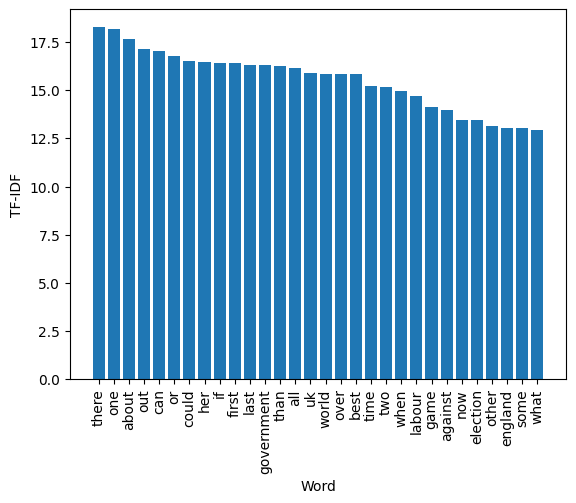

In [157]:
train_featured_names = train_vector.get_feature_names_out().reshape(1,-1)
train_word_count = train_matrix.sum(axis=0).reshape(1,-1)
trainIndex = np.argsort(train_word_count)[0,::-1]

#Plot highest leverage words
n_to_plot = 30


trainPlotNames = train_featured_names[0, trainIndex][0, 50 : 50 + n_to_plot].tolist()
trainPlotTFIDF = train_word_count[0, trainIndex][0, 50 : 50 + n_to_plot][0,:].tolist()[0]

plt.bar(trainPlotNames,trainPlotTFIDF)
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("TF-IDF")
plt.show()

Mean text length: 2234.2618055555554
Min length: 501
Max length: 18387


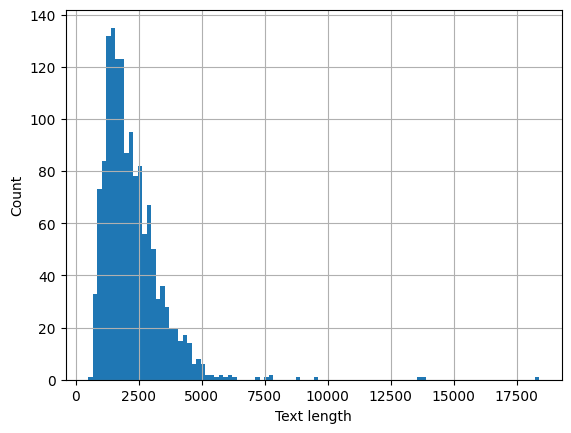

In [158]:
text_lenght = train_data["Text"].apply(lambda x: len(x))
text_lenght.hist(bins=100)
plt.ylabel("Count")
plt.xlabel("Text length")
print(f"Mean text length: {text_lenght.mean()}\nMin length: {text_lenght.min()}\nMax length: {text_lenght.max()}")
plt.show()

In [165]:
print("\nOriginal train shape:", train_data.shape)
print("The mean number of category is ", train_data.Category.value_counts().mean())
print(train_data.Category.value_counts())

train_data = train_data.groupby("Category").apply( lambda group: group.sample(n = min(len(group), int(mean_count)), random_state=42)).reset_index(drop=True)

print("\nNew train shape:", train_data.shape)
print("The mean number of category is ", train_data.Category.value_counts().mean())
print(train_data.Category.value_counts())


Original train shape: (1440, 3)
The mean number of category is  288.0
Category
sport            342
business         335
politics         266
entertainment    263
tech             234
Name: count, dtype: int64

 New train shape: (1339, 3)
The mean number of category is  267.8
Category
business         288
sport            288
politics         266
entertainment    263
tech             234
Name: count, dtype: int64


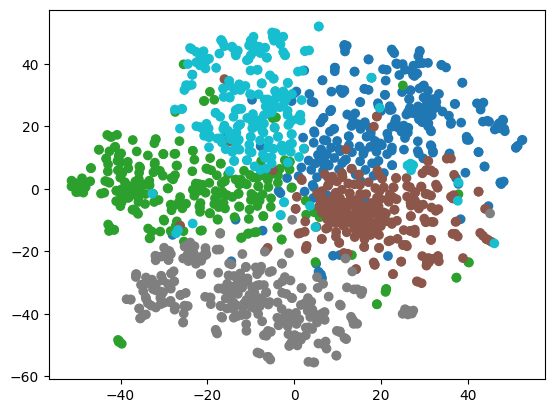

In [184]:
tsne = TSNE(n_components=2, random_state=42, init="random")
tfid_weights_train, tfid_vectorizer_train = extract_tifd(train_data)
tsne_train = tsne.fit_transform(tfid_weights_train)
plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c=train_data['Category'].astype('category').cat.codes, cmap='tab10')
plt.show()